# This notebook containts analysis for ASO 50m snow depths

In [5]:
import pandas as pd
import numpy as np

from skimage import io
from datetime import timedelta
from datetime import datetime
from scipy.stats import pearsonr
from subprocess import run
import imageio # for gifs
import glob
import os

# Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter 
from matplotlib.ticker import MultipleLocator, FormatStrFormatter 
from matplotlib.dates import MonthLocator
import matplotlib.patheffects as PathEffects

from mpl_toolkits.axes_grid1 import make_axes_locatable

### set up paths

In [6]:
# # #ARS
# # mask and DEM
mask_50m_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/tuolx_hetchy_mask_50m.asc'
dem_50m_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/tuolx_dem_50m.asc'

# ASO snow depth surfaces
depth_50m_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/ASO_50m_depth_surfaces/asc/*.asc'
depth_50m_years = list(range(2013,2018))

In [7]:
# # #BSU
# base_path = '/Users/meganmason491/Documents/research/sierra/data/50m_analysis/'

# # mask and DEM
# mask_50m_path = base_path + 'tuolx_hetchy_mask_50m.asc'
# dem_50m_path = base_path + 'tuolx_dem_50m.asc'

# # ASO snow depth surfaces
# depth_50m_path = base_path + 'asc/*.asc'
# depth_50m_years = list(range(2013,2018))

### extract flight dates from filenames

In [8]:
flist = glob.glob(depth_50m_path)
flist = sorted(flist)
print('Number of files as input:', len(flist))

flight_dates = []

for f in sorted(flist):
    dt_str = f.split("/")[-1] #splits on '/' and saves the last one
    dt_str = "".join([c for c in dt_str if c.isnumeric()]) #grabs numeric values for date info
    flight_dates.append(dt_str) #append to flight_date list

# flight_dates # flight dates as strings

flight_dates_dt = [datetime.strptime(flight_date, '%Y%m%d') for flight_date in flight_dates]
# print(flight_dates_dt[1] - flight_dates_dt[0])
# print(type(flight_dates_dt))    

Number of files as input: 47


### show mask, dem, and example lidar

mask shape: (1339, 1374) 
dem shape: (1339, 1374) 
example lidar shape: (1339, 1374)

mask type: <class 'numpy.ndarray'> 
dem type: <class 'numpy.ndarray'> 
example lidar type: <class 'numpy.ndarray'>


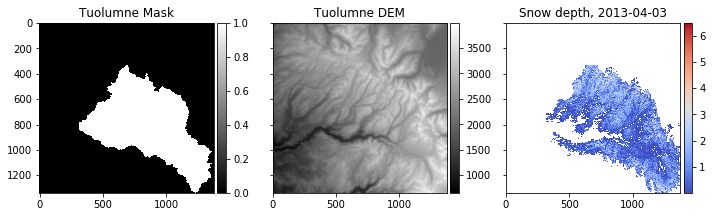

In [9]:
mask_50m = np.loadtxt(mask_50m_path, skiprows=6)
dem_50m = np.loadtxt(dem_50m_path, skiprows=6)
ex_depth = np.loadtxt(flist[0], skiprows=6)

print('mask shape:', mask_50m.shape, 
      '\ndem shape:', dem_50m.shape, 
      '\nexample lidar shape:', ex_depth.shape)

print('\nmask type:', type(mask_50m), 
      '\ndem type:', type(dem_50m), 
      '\nexample lidar type:', type(ex_depth))


f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10,6))
#mask
im1 = ax1.imshow(mask_50m, cmap='gray')
ax1.set_title('Tuolumne Mask')
divider = make_axes_locatable(ax1)
plt.colorbar(im1, cax=divider.append_axes("right", size="5%", pad=0.05))
#dem
im2 = ax2.imshow(dem_50m, cmap='gray')
ax2.set_title('Tuolumne DEM')
divider = make_axes_locatable(ax2)
plt.colorbar(im2, cax=divider.append_axes("right", size="5%", pad=0.05))
#snow depth, 1 of 48
ex_depth[ex_depth<=0]=np.nan
im3 = ax3.imshow(ex_depth, cmap='coolwarm') 
ax3.set_title('Snow depth, {}'.format(flight_dates_dt[0].date())) 
divider = make_axes_locatable(ax3) 
plt.colorbar(im3, cax=divider.append_axes("right", size="5%", pad=0.05))

plt.tight_layout()

In [10]:
flight_period = {}
for year in range(2013,2018):

    flight_period[year] = [flight_dates_dt[i_date+1] - flight_dates_dt[i_date] 
                           for i_date in range(len(flight_dates_dt)-1) 
                           if (year == flight_dates_dt[i_date+1].year) & (year == flight_dates_dt[i_date].year)]
    
    print('frequencies for {}: {} - {} days'.format(year, min(flight_period[year]).days, max(flight_period[year]).days))

frequencies for 2013: 4 - 26 days
frequencies for 2014: 4 - 15 days
frequencies for 2015: 4 - 27 days
frequencies for 2016: 5 - 18 days
frequencies for 2017: 8 - 35 days


### Tuolumne Basin Mean Snow Depth 

In [11]:
# ~~ Function 1, mean snow depth
def mean_snow_depth(depth_array, convert_factor = 1e-3, mask_array = None, mask_value = None):
    '''
    Gets mean snow depth for ASO snow depth surfaces
        args:
            depth_array: numpy array from asc files
            dx: cellsize [m] in x direction
            dy: cellsize [m] in y direction
            convert_factor: (optional, default is 0.001 from mm to m)
            mask_array: (Optional) mask of the area for depth calculation
                       If no mask is provided will calculate for entire array
            mask_value: (Optional) value of the mask to calculate over
                       Default value will be any positive integer
           Note: depth_array and mask_array should cover the same extent 
                 and have the same dx,dy
       return:
           mean_depth: mean depth [m] over the area in mask
                       or the full area in the array if no mask is provided
    '''
    
    if mask_array is None:
        mean_depth = np.nanmean(depth_array[(depth_array > 0)])
        sca = depth_array[(depth_array > 0)].size / mask_array[mask_array == mask_value].size
        
    else:
        mean_depth = np.nanmean(depth_array[[(mask_array == mask_value) & (depth_array > 0)]])
        sca = (depth_array[[(mask_array == mask_value) & (depth_array > 0)]].size / mask_array[mask_array == mask_value].size) * 100
        
    return mean_depth, sca

In [12]:
# call Function 1
mean_depth = []
sca = []

for f in sorted(flist):
    depth_array = np.loadtxt(f, skiprows=6) #load asc files
    mean_d, sca_ = mean_snow_depth(depth_array, mask_array=mask_50m, mask_value=np.max(mask_50m)) #call mean_snow_depth function
    mean_depth.append(mean_d)
    sca.append(sca_)

# mean_depth_df = pd.DataFrame(data = mean_depths, index = flight_dates_dt, columns = ['mean_snow_depth'])
# sca_df = pd.DataFrame(data = sca, index = flight_dates_dt, columns = ['sca'])

df = pd.DataFrame(zip(mean_depth, sca), columns = ['meanSD (m)','SCA (%)'], index = flight_dates_dt)
# df

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [13]:
# ~~ Function 2, peak mean snow depth per year
def get_peak(datetime_list, series_list, years):
    '''
    Calculates yearly peak mean depth
    input:
        datetime_list: list containing the datetime stamps for the time series
        series_list: list with the time series of mean depth values
        years: list with years to analyze
    return:
        peak_df: yearly peak value dataframe with datetime_peak as index and peak value in column
    '''
    
    
    df_series = pd.DataFrame(data = series_list, index = datetime_list, columns = ['series'])
    
    for year in years:
        df_year = df_series.truncate(before = str(year) + '-01', after = str(year) + '-12')
        if year == years[0]:
            peak_df = pd.DataFrame(data = [df_year.max(axis = 0).values[0]], index = [df_year.idxmax(axis = 0).values[0]], columns = ['peak mean depth'])
        else:
            peak_df.loc[df_year.idxmax(axis = 0).values[0]] = df_year.max(axis = 0).values[0]
    
    return peak_df

In [14]:
# call Function 2

# peak mean depths
peak_mean_depth_df = get_peak(flight_dates_dt, mean_depth, depth_50m_years)
# peak_mean_depth_df 

#peak sca
peak_sca_df = get_peak(flight_dates_dt, sca, depth_50m_years)
# peak_sca_df

## PLOT: mean snow & snow covered area

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes in

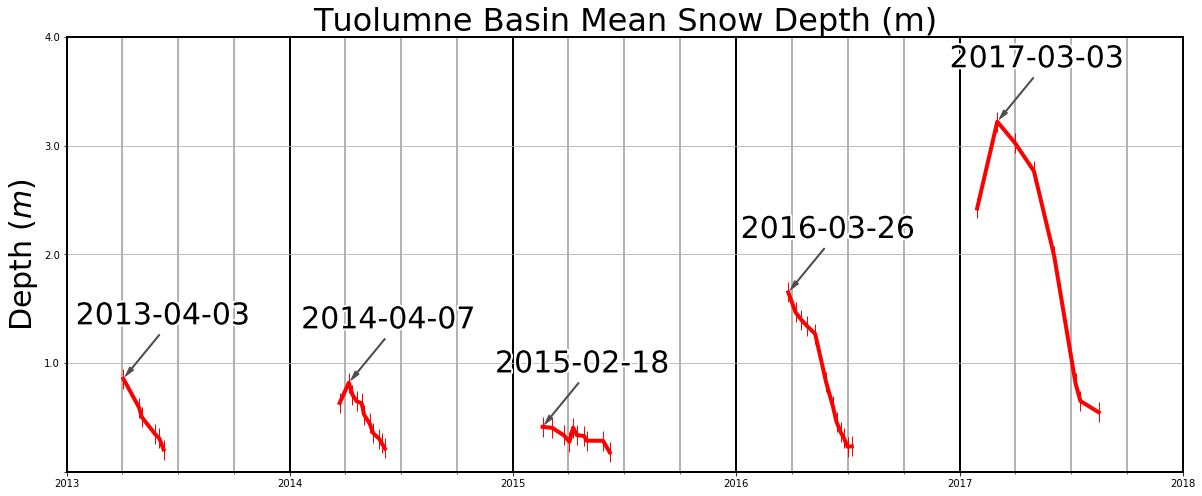

In [15]:
#~~~~use:
# df['meanSD (m)'] (func 1)
# peak_mean_depth_df (func 2)

minorLocator = MultipleLocator(365/2)
fs_titles = 32
fs_labels = 26
fs_axes = 26
fs_text = 26
fs_legend = 26

plt.figure(figsize=(20,8))
ax = plt.subplot(1, 1, 1)

i_plot = 0
for year in depth_50m_years: #(list(range(2013,2018)))
    depth_year = df['meanSD (m)'].truncate(before = str(year) + '-01', after = str(year) + '-12')
    h_plot = plt.plot_date(depth_year.index, depth_year.values, fmt='x', tz=None, xdate=True, ydate=False)
    
    plt.setp(h_plot, marker='|', markersize=20, color='r', linestyle = '-', linewidth = '4')
    
    h_text_date = plt.annotate(str(peak_mean_depth_df.index[i_plot])[:10], xy=(peak_mean_depth_df.index[i_plot], peak_mean_depth_df.iloc[i_plot]), 
                               xytext=(peak_mean_depth_df.index[i_plot]+pd.Timedelta('65 days'), peak_mean_depth_df.iloc[i_plot] + 0.5),
                arrowprops=dict(shrink=0.05, width=1, headlength = 10, headwidth = 5, edgecolor= (0.3, 0.3, 0.3), facecolor= (0.3, 0.3, 0.3)),
                fontsize = fs_text+4, horizontalalignment='center')
    
    h_text_date.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])

    i_plot += 1

plt.title('Tuolumne Basin Mean Snow Depth (m)', fontsize = fs_titles)
plt.ylabel('Depth $(m)$',fontsize = fs_labels + 4)
plt.axes().xaxis.set_minor_locator(MonthLocator(bymonth = [4, 7, 10]))
plt.rc('xtick', labelsize = fs_axes+10)    # fontsize of the tick labels
plt.rc('ytick', labelsize = fs_axes+4)    # fontsize of the tick labels
plt.ylim([0, 4])
plt.grid(True)
plt.grid(axis='both', color=(0.7, 0.7, 0.7), which='minor', linestyle='-', linewidth=2)
plt.grid(axis='x', color='k', which='major', linestyle='-', linewidth=2)
plt.xlim([pd.to_datetime('2013-01-01'), pd.to_datetime('2018-01-01')])

y_ticks = np.array(list(range(0, 45, 10)))/10
y_ticklabels = [str(y_tick) for y_tick in y_ticks]
y_ticklabels[0] = ''
plt.yticks(y_ticks, y_ticklabels)

ax.spines['top'].set_linewidth(2.0)
ax.spines['bottom'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)

# plt.savefig('/home/meganmason/Documents/projects/thesis/figures/working/50m_depth/mean_snow_depth.png', dpi=300)

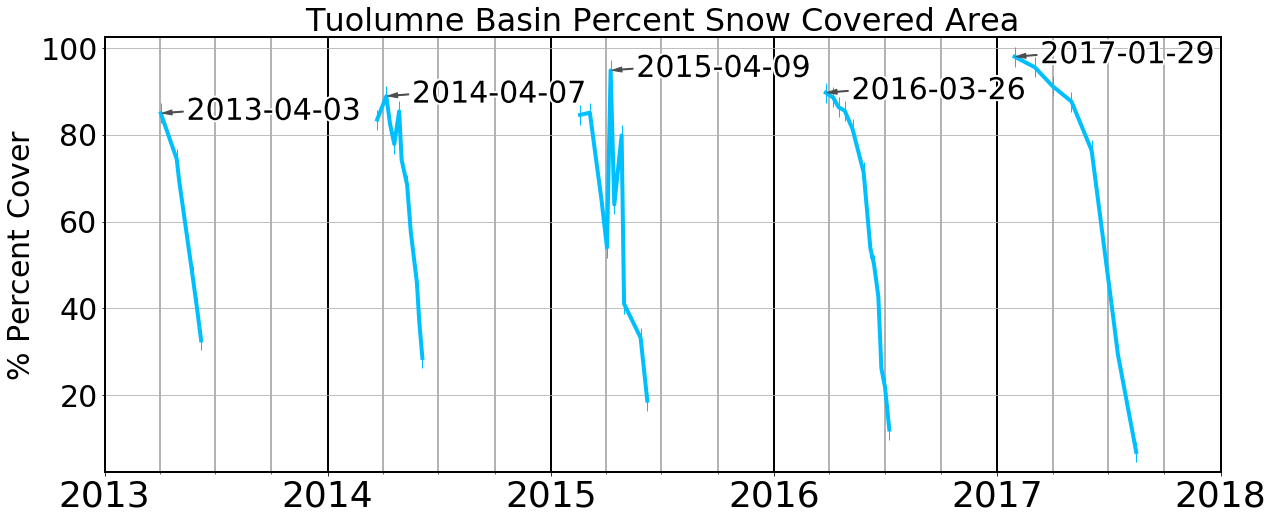

In [16]:
#use:
# df['SCA (%)'] (func 1)
# peak_sca_df (func 2)

minorLocator = MultipleLocator(365/2)
fs_titles = 32
fs_labels = 26
fs_axes = 26
fs_text = 26
fs_legend = 26

plt.figure(figsize=(20,8))
ax = plt.subplot(1, 1, 1)

i_plot = 0
for year in depth_50m_years: #(list(range(2013,2018)))
    depth_year = df['SCA (%)'].truncate(before = str(year) + '-01', after = str(year) + '-12')
    h_plot = plt.plot_date(depth_year.index, depth_year.values, fmt='x', tz=None, xdate=True, ydate=False)
    
    plt.setp(h_plot, marker='|', markersize=20, color='deepskyblue', linestyle = '-', linewidth = '4')
    
    h_text_date = plt.annotate(str(peak_sca_df.index[i_plot])[:10], xy=(peak_sca_df.index[i_plot], peak_sca_df.iloc[i_plot]), 
                               xytext=(peak_sca_df.index[i_plot]+pd.Timedelta('185 days'), peak_sca_df.iloc[i_plot] - 1.5),
                arrowprops=dict(shrink=0.05, width=1, headlength = 10, headwidth = 5, edgecolor= (0.3, 0.3, 0.3), facecolor= (0.3, 0.3, 0.3)),
                fontsize = fs_text+4, horizontalalignment='center')
    
    h_text_date.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])

    i_plot += 1

plt.title('Tuolumne Basin Percent Snow Covered Area', fontsize = fs_titles)
plt.ylabel('$\%$ Percent Cover', fontsize = fs_labels + 4)
plt.axes().xaxis.set_minor_locator(MonthLocator(bymonth = [4, 7, 10]))
plt.rc('xtick', labelsize = fs_axes+10)    # fontsize of the tick labels
plt.rc('ytick', labelsize = fs_axes+4)    # fontsize of the tick labels
# plt.ylim([0, 4])
plt.grid(True)
plt.grid(axis='both', color=(0.7, 0.7, 0.7), which='minor', linestyle='-', linewidth=2)
plt.grid(axis='x', color='k', which='major', linestyle='-', linewidth=2)
plt.xlim([pd.to_datetime('2013-01-01'), pd.to_datetime('2018-01-01')])

ax.spines['top'].set_linewidth(2.0)
ax.spines['bottom'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)

# plt.savefig('/home/meganmason/Documents/projects/thesis/figures/working/50m_depth/sca_depth.png', dpi=300)

In [ ]:
# What are the maximums for each year??
depth_max = []
for f in sorted(flist):
    depth_array = np.loadtxt(f, skiprows=6) #load lidar asciis
    d_max = depth_array[mask_50m == 1].max()
    depth_max.append(d_max)
depth_max
max_depth_df = pd.DataFrame(data = depth_max, index = flight_dates_dt, columns = ['max_snow_depth'])
# max_depth_df

## Histograms :)

In [17]:
def hist2series(bin_edges, hist_series):
    '''
    Generates x-y series to plot histograms as a line/step plot
    Parameters: bin_edges: (ndarray, list) monotonically increasing array of bin edges,
                            excluding the rightmost edge
                hist_series: (ndarray, list) The values of the histogram
                            (len(bin_edges) -1)
                Note: bin_edges and hist_series should be the same length
    Returns:
            x_series: (list) x values for plotting
            y_series: (list) y values for plotting
    '''
    
    x_series = []
    y_series = []
    
    for i_bin in range(len(bin_edges) - 1):
        
        x_series += [bin_edges[i_bin], bin_edges[i_bin+1]]
        y_series += [hist_series[i_bin], hist_series[i_bin]]
        
    return x_series, y_series

In [98]:
bin_size = 10 #0.10 #m (5cm)
max_depth = 2500
bins_ll = np.arange(0, max_depth, bin_size)

# bin_edges = np.arrange(0, 25, bin_size)

depth_tuolumne_hist = {}

for i, flight_date_dt in enumerate(flight_dates_dt):
    
    hist_aux = pd.DataFrame(data = np.nan, index = bins_ll[:-1], columns = [flight_date_dt])
    
    depth_array = np.loadtxt(flist[i], skiprows=6) * 100 #load lidar asciis
    
#     depth_array=depth_array*100
    
    hist_aux[flight_date_dt] = np.histogram(depth_array[(depth_array > 0) & (mask_50m == 1)], bins = bins_ll)[0] #saves just histogram result
    
    depth_tuolumne_hist[flight_date_dt] = hist_aux
# depth_tuolumne_hist

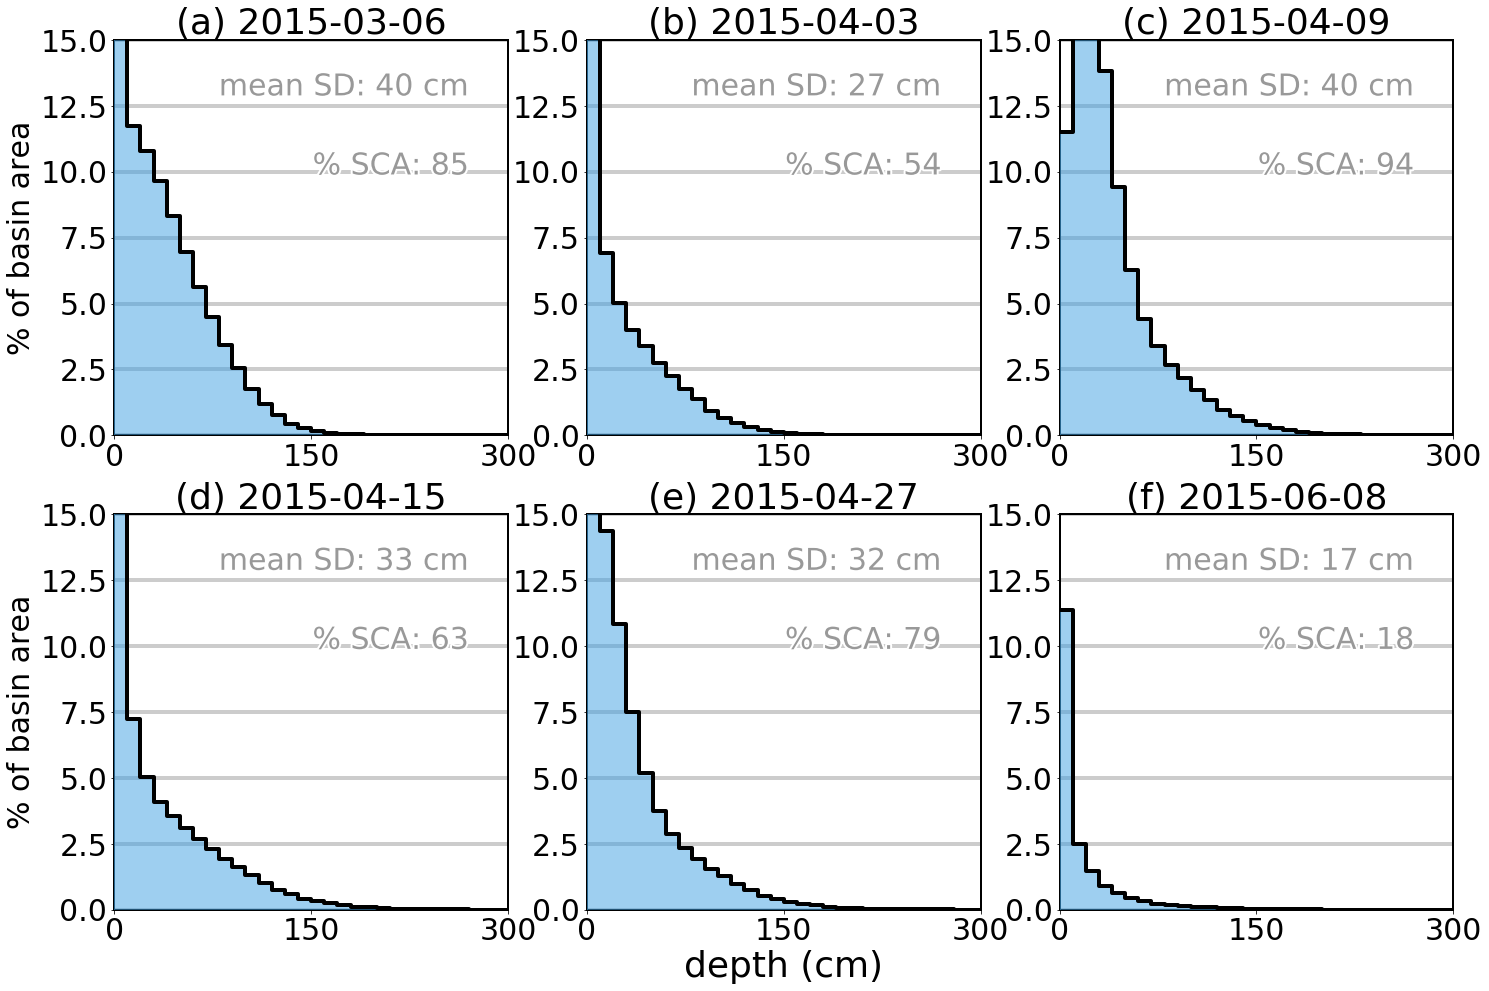

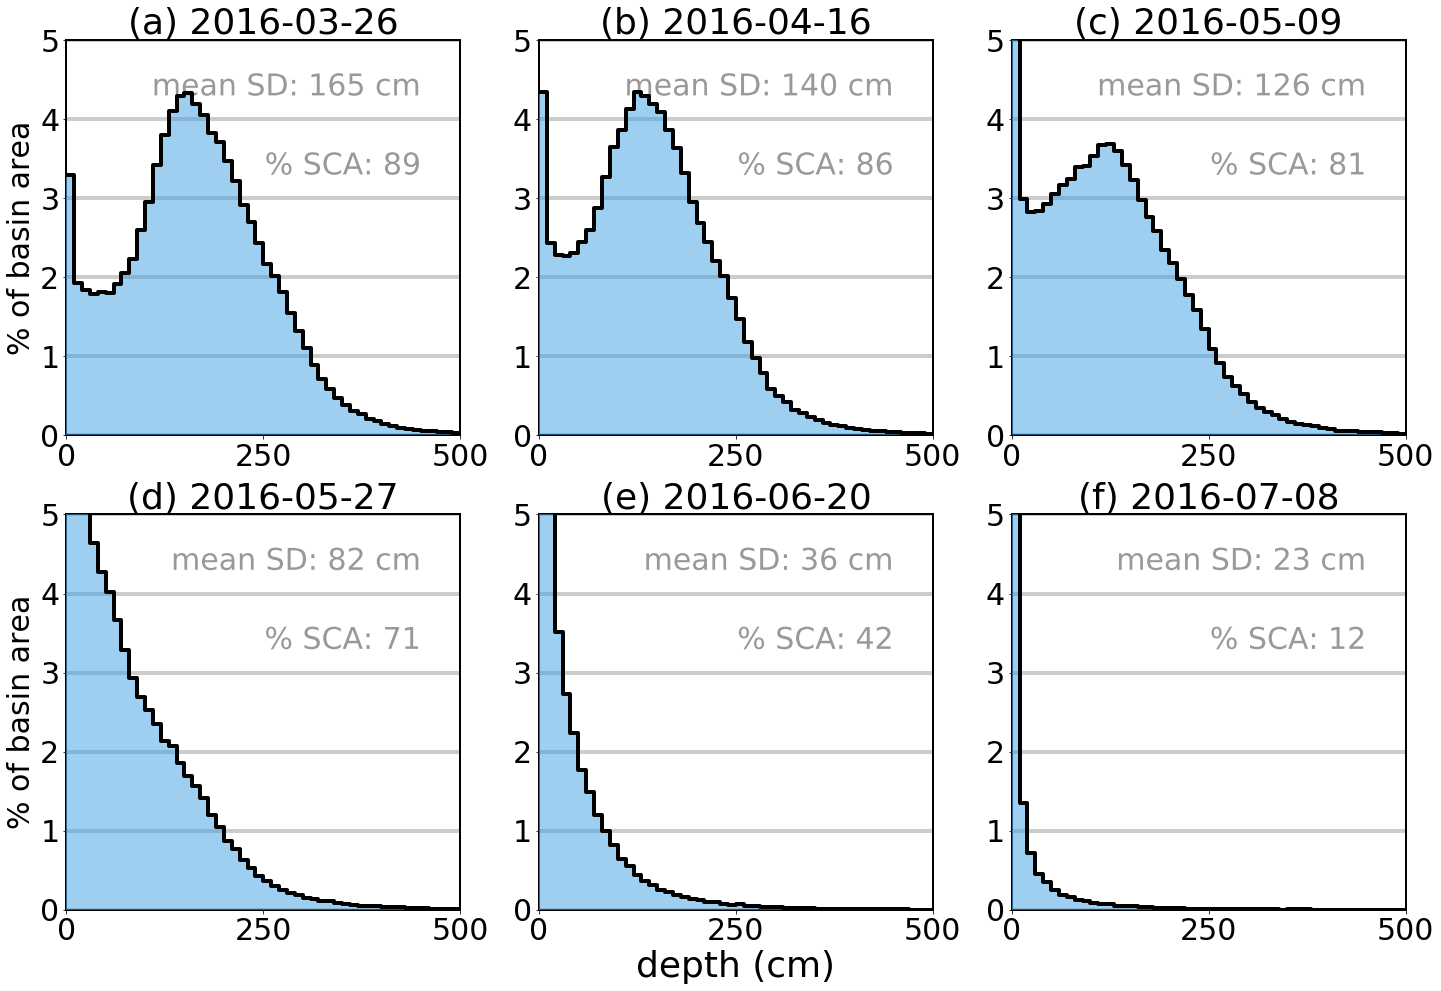

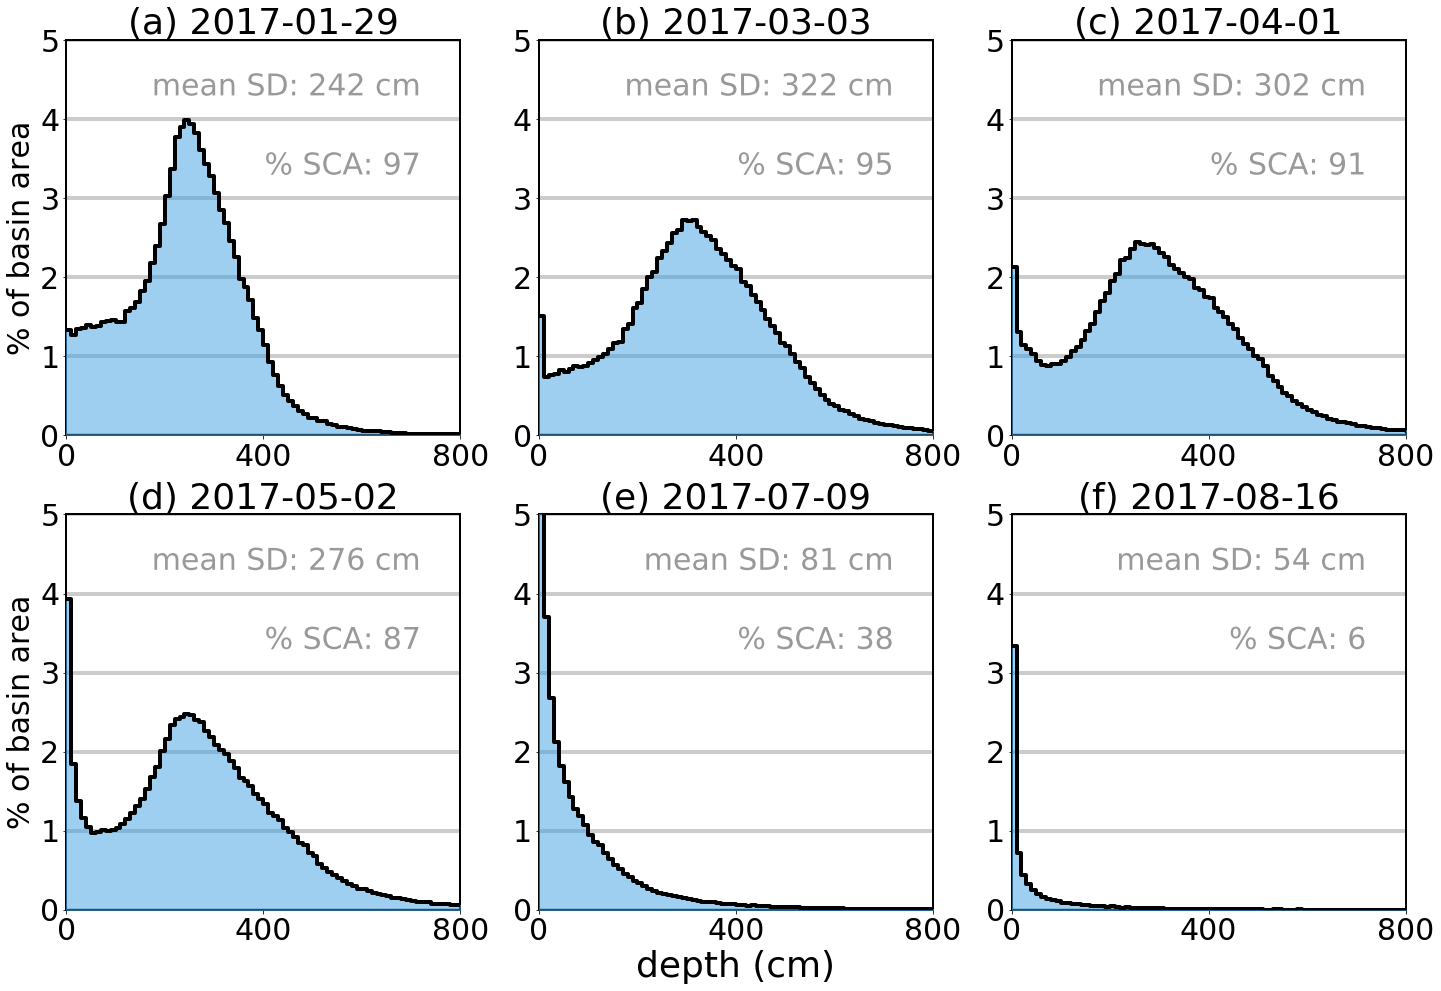

In [99]:
# plots with optimal bins

# low: 2015
# middle: 2016
# high: 2017

dates_to_plot_dict = {2015:['20150306', '20150403', '20150409', '20150415', '20150427', '20150608'],
                      2016:['20160326', '20160416', '20160509', '20160527', '20160620', '20160708'],
                      2017:['20170129', '20170303', '20170401', '20170502', '20170709', '20170816']}

color_plots = [(62/255, 160/255, 227/255), 'k']
max_depth = {2015:300, 2016:500, 2017:800}
max_y = {2015:15, 2016:5, 2017:5}
title_letter = 'abcdef'


for year in dates_to_plot_dict: #('15,'16,'17)
       
    plt.figure(figsize = (24, 16))
    i_plot = 1
    
    for year_date in dates_to_plot_dict[year]:
        
        #~~~ plot
        ax = plt.subplot(2, 3, i_plot)
        
        #extract data from dataframe
        year_date_dt = datetime.strptime(year_date, '%Y%m%d') #formats the strings in the dates_to_plot_dict
        depth_hist_aux = depth_tuolumne_hist[year_date_dt] #pulls individual histogram for each date
        
        # compute x and y series for step plot from histogram values
            # x'= hist_xy[0] and 'y'= hist_xy[1]
            # y = % of basin, divide by size of pixels in mask and *100 for percent of basin       
        hist_xy = hist2series(depth_hist_aux.index, depth_hist_aux[year_date_dt].values) 
        ax.plot(hist_xy[0], 100 * np.array(hist_xy[1])/mask_50m[mask_50m == 1].size,
                label=year_date_dt, linewidth = 4, color = 'k', zorder = 5)
        plt.fill_between(hist_xy[0], 100 * np.array(hist_xy[1])/mask_50m[mask_50m == 1].size, alpha = 0.5, color = color_plots[0], zorder = 4) #color_plots different than ET
        
        
        
        #~~~ format
        plt.title('(' + title_letter[i_plot-1] + ') ' + str(year_date_dt.strftime('%Y-%m-%d')), fontsize = fs_titles+4)
    
        if i_plot == 5:
            plt.xlabel('depth (cm)',fontsize = fs_labels + 10)
    
        if i_plot in [1, 4]:
            plt.ylabel('% of basin area',fontsize = fs_labels + 4)

        plt.xticks(np.arange(0, 3*max_depth[year]/2, max_depth[year]/2))
        plt.rc('xtick', labelsize = fs_axes+4)    
        plt.rc('ytick', labelsize = fs_axes+4)    

        plt.grid(axis='y', color=(0.8, 0.8, 0.8), which='major', linestyle='-', linewidth=4)

        plt.xlim([0, max_depth[year]])
        plt.ylim([0, max_y[year]])

        ax.spines['top'].set_linewidth(2.0)
        ax.spines['bottom'].set_linewidth(2.0)
        ax.spines['left'].set_linewidth(2.0)
        ax.spines['right'].set_linewidth(2.0)
        
        sca_percent = depth_hist_aux[year_date_dt].values.sum() / mask_50m[mask_50m == 1].size * 100
        sca_text = plt.annotate('% SCA: ' + str(int(sca_percent)), 
                                xy = (0.9*max_depth[year], 0.66*max_y[year]), 
                                fontsize = fs_labels+4, color = (0.6, 0.6, 0.6), alpha = 1, rotation = 0, 
                                horizontalalignment = 'right')
        sca_text.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])

        mean_text = plt.annotate('mean SD: ' + str(int(df['meanSD (m)'].loc[year_date_dt] *100)) + ' cm', 
                                xy = (0.9*max_depth[year], 0.86*max_y[year]), 
                                fontsize = fs_labels+4, color = (0.6, 0.6, 0.6), alpha = 1, rotation = 0, 
                                horizontalalignment = 'right')
        mean_text.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        
        
        i_plot +=1
        
#     plt.savefig('/home/meganmason/Documents/projects/thesis/figures/working/50m_depth/hist_sca_depth_{}.png'.format(year), dpi=150)